## MIDS UC Berkeley, Machine Learning at Scale Assignment 7
 
__W261-1__ Summer 2016    
__Week 7__: SSSP    

Jackson Lane   

***

<h1 style="color:#021353;">General Description</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

<h3>Undirected toy network dataset</h3>


In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt
On under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


<h3>Directed toy network dataset</h3>

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

<h1 style="color:#021353;">HW 7.0: Shortest path graph distances (toy networks)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

.and report your output---make sure it is correct!

In [3]:
%%writefile MRJob7_0_findshortestpath.py

#This job takes in a graph file, optionally an index file, a start point or name, and an end point or name.  
#The job will then find the shortest path between the start and points using breadth first search
# There are two general sections of this job
#The first is the pre-processing.  Here, the graph data is transformed in the following ways:
#   -Initialize fields for visit status, distance, and shortest path
#   -Join graph data with name from index file if present
#   -Put start point into queue

# In the second phase, the breadth first search algorithm is applied repeatedly until either it finds the end point
# or it runs out of nodes to process.  
# This phase will also terminate after 999 iterations.
# Each iteration of breadth first search will:
#   -Update the statuses of the nodes currently in queue and add their neighbors to the queue
#   -Update the shortest paths and distances of the nodes currently in queue
#   -Terminate if either the end node has been reached or if there are no nodes left to process

# The second phase passes back either the shortest path to the end node or an error message

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class MRJob7_0_findshortestpath(MRJob):
    MRJob.SORT_VALUES = True
    
    def steps(self):
        #Run 999 iterations of BFS search
        step =  [MRStep(
                    mapper=self.mapper
                       , reducer=self.reducer
                ,jobconf =  {
            "mapred.map.tasks":4,
            "mapred.reduce.tasks":2
        }
                      )
               ] 
        return [MRStep(mapper=self.mapper_preprocess,reducer=self.reducer_preprocess
            ,jobconf =  {
            "mapred.map.tasks":4,
            "mapred.reduce.tasks":2
        })] + step * 999
    
    def configure_options(self):
        super(MRJob7_0_findshortestpath, self).configure_options()
        self.add_passthrough_option('--startNode', default='1')
        self.add_passthrough_option('--endNode', default='1')

    def mapper_preprocess(self, _, line):
        fields = line.strip().split('\t')
        #Check if line comes from a graph data file
        # or an index file.  You usually can tell if its
        # a graph data file if the first field is a number.
        if fields[0].isdigit():
            id = fields[0]
            neighbors = eval(fields[1])
            # if it turns out that this was actually a line from an index file
            # and the node name was just all numeric, then discard
            if(str(type(neighbors)) == "<type 'dict'>"):
                yield id, neighbors
        else:
            # if line is from an index file, yield node id and name with order inversion
            id = fields[1]
            name = fields[0]
            yield id, {"*":name}
    
    # The reducer here will perform left on graph data with the names from the index file, if present.
    def reducer_preprocess(self,id,values):
        name = id
        id = int(id)
        for neighbors in values:
            if neighbors.get("*"):
                name= neighbors["*"]
            else:
                if name == self.options.startNode:
                    yield id, [name,neighbors, 0, 'queue', []]
                else:
                    yield id,[name, neighbors,sys.maxint, 'frontier', []]

    # This mapper takes in a node and computes the results of a BFS search iteration on that node.
    # The mapper then yields the resulting nodes from that BFS search.
    def mapper(self, node, values):
        name,neighbors, distance, status,shortest_path = values
        node = str(node)
        neighbors = map(str,neighbors)
        # First part of termination condition.  Each mapper will yield a special key *Q with value 0
        # If the mapper processes any queued elements, it will emit *Q with a value of 1
        # In the reducer, if none of the mappers emitted *Q with a value of 1, then that means
        # the queue is empty and there is no path between the start and end nodes.
        yield "*Q",0
        self.increment_counter("7_0","NA",1)

        if status == 'queue':
            #Yield *Q,1 to indicate that the mapper has processed a node in queue and that there are still
            # nodes left to process in the graph
            yield "*Q",1
            if(name == self.options.endNode):
                self.increment_counter("7_0",map(str,shortest_path),1)
                
            # Update status from "queue" to "visited"and yield
            yield node, [name,neighbors, distance, 'visited', shortest_path]
            if neighbors:
                #Yield each of node's neighbors.
                #Note that mapper does not have any information on the neighbors
                    # except for node id.  So the mapper just emits what it can,
                    # and it's up to the reducer to fill in the missing information
                for neighbor in neighbors:
                    temp_path = list(shortest_path)
                    temp_path.append(name)
                    yield neighbor, ['',None, distance + 1, 'queue', temp_path]
        else:
            #Even if a node has been visited before or is on the frontier, the mapper still yields it
            # so that reducer can use it to fill in missing information if needed
            yield node, [name,neighbors, distance, status, shortest_path]


    #The reducer fills in the missing information for each of the nodes emitted by the mapper
    #The reducer also will terminate the MRJob if the endNode is found or
    # if the mapper did not process any nodes in status "queue"
    def reducer(self, key, values):
        if key == "*Q": 
            queue_count = sum(values)
            if (queue_count == 0):
                raise Exception("No Path")
        else:
            name = ""
            neighbors = {}
            distance = sys.maxint
            status = None
            path = []
            for value in values:
                # If the reducer runs into a visited node, the reducer assumes all information is present
                # If the visited node is the endNode, the reducer terminates the job
                if value[3] == 'visited':
                    [name,neighbors,distance,status,path] = value
                    if(name == self.options.endNode):
                        raise Exception("Success")                    
                    break
                
                #Handle frontier nodes.
                elif value[3] == "frontier":
                    name = value[0]
                    neighbors = value[1]
                    #If we previously processed a queued node, with same ID, then leave status as queue
                    #Otherwise, update status to frontier
                    if status != 'queue':
                        status = value[3]

                # Handle queued nodes.  This type of node should always come with a frontier node with the same ID
                # The frontier node updates the name and neighbors while the queued node updates the status and path
                else:
                    status = value[3]
                    path = value[4] 
                distance = min(distance, value[2])
            
            # After all values are processed, yield node
            yield key, [name,neighbors, distance, status, path]

if __name__ == '__main__':
    MRJob7_0_findshortestpath.run()

Overwriting MRJob7_0_findshortestpath.py


In [4]:
# Driver function to call the findshortestpath MRJob.  
# It passes the graph data file and index file if present to the MRJob.  
# StartNode, endNode, and runnerType are all parameterized, making this driving function backend agnostic
# Since the MRJob should terminate early, the driver function actually handles the results of the MRJob in
# a try-catch statement.

%load_ext autoreload
%autoreload 2
from MRJob7_0_findshortestpath import MRJob7_0_findshortestpath
import os
def findShortestPath(filenames, startNode, endNode,runnerType):
    # Separate graph data file from index file (if present)
    filenames = filenames.split()
    fileData = filenames[0]
    if (len(filenames) > 1):
        fileIndex = filenames[1]
    else:
        fileIndex = ''
    mr_job = MRJob7_0_findshortestpath(args=[
        fileData,fileIndex, '-r', runnerType,
        '--startNode', startNode,
        '--endNode',endNode
    ])
    with mr_job.make_runner() as runner:
        try:
            runner.run()
        except:
            #The MRJob should terminate early when it finds the endNode or runs out
            # of nodes to process.  Since MRJob does not let you stream_output on
            # jobs that have terminated early, the MRJob uses counters to pass
            # the shortest path to the driver function.  
            counters = sorted(runner.counters()[-1]["7_0"].keys())
            path =counters[-1].replace(";",",")
            if path == "NA":
                raise Exception("No path")
            path = map(str,eval(path))
            # Append endNode to the path.  The MRJob path alone only shows nodes leading up to end node
            return path + [endNode] 
    raise Exception("No Path after 999 iterations")

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test against toy data 

In [37]:
%%writefile toy_indicies.txt
A	1
B	2
D	3
C	4

Overwriting toy_indicies.txt


In [38]:
# Testing undirected toy with index file
filename = 'Data/undirected_toy.txt toy_indicies.txt'
print 'Shortest path in', filename
# Because we are using an index file, we refer to nodes by name rather than ID
path = findShortestPath(filename, 'A', 'D','local')
print path

Shortest path in Data/undirected_toy.txt toy_indicies.txt
['A', 'B', 'D']


In [18]:
# Testing directed toy without index file
filename = 'Data/directed_toy.txt'
print 'Shortest path in', filename
path = findShortestPath(filename, '1', '5','local')
print path

Shortest path in Data/undirected_toy.txt toy_indicies.txt
['A', 'B', 'D']
Shortest path in Data/directed_toy.txt
['1', '2', '4', '5']


<h3>Main dataset 1: NLTK synonyms</h3>

In the next part of this assignment you will explore a network derived from the NLTK synonym database used for evaluation in HW 5. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:

<a href="s3://ucb-mids-mls-networks/synNet/synNet.txt">s3://ucb-mids-mls-networks/synNet/synNet.txt</a>
<a href="s3://ucb-mids-mls-networks/synNet/indices.txt">s3://ucb-mids-mls-networks/synNet/indices.txt</a>
On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

<h1 style="color:#021353;">HW 7.1: Exploratory data analysis (NLTK synonyms)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).
</pre>
</div>


In [223]:
%%writefile MRJob7_1_findnodes.py

#MR Job code to find all the nodes in a graph.  It does this by emitting a key for each node id found.

from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep

class MRJob7_1_findnodes(MRJob):

    def mapper(self, _, line):
        node, neighbors = line.strip().split('\t')
        neighbors = eval(neighbors)
        yield str(node), 1
        #Since the graph data file only has nodes with out links, we also need to emit each neighbor to
        # ensure that we also cover nodes that may only have in links but no out links.
        # On Wikipedia in particular, these 
        for (node,_) in neighbors.items():
            yield str(node), 1

    def combiner(self, node, values):
        # Even if there are duplicates, emit a value of 1.  
        # We only want to know whether a node exists, not its degree
        yield str(node), 1
            
    def reducer(self, node, values):
        yield str(node), 1

if __name__ == '__main__':
    MRJob7_1_findnodes.run()

Overwriting MRJob7_1_findnodes.py


In [4]:
%%writefile MRJob7_1_findlinks.py

#MR Job code to find all the edges in a graph.  It does this by creating a frequency distribution of out degree

from mrjob.job import MRJob
from mrjob.step import MRStep

class MRJob7_1_findlinks(MRJob):

    def mapper(self, _, line):
        node, neighbors = line.strip().split('\t')
        neighbors = eval(neighbors)
        # compute the degree of the node and yield 
        degree = len(neighbors)
        yield degree, 1

    def combiner(self, degree, counts):
        # Sum up counts
        yield degree, sum(counts)
   
    def reducer(self, degree, counts):
        yield degree, sum(counts)
   
if __name__ == '__main__':
    MRJob7_1_findlinks.run()

Overwriting MRJob7_1_findlinks.py


Driver class

In [5]:
# This is a driver function to call the findNodes and findEdges MRJobs.  
# It will generate a file with the results that can be used in the next function
# to show EDA 

from __future__ import division
from MRJob7_1_findnodes import MRJob7_1_findnodes
from MRJob7_1_findlinks import MRJob7_1_findlinks
import numpy

def exploreData(filename,runnerType):
    mr_job = MRJob7_1_findnodes(args=[
        filename, '-r', runnerType ])
    nodes = 0
    
    #Run find nodes MRJob
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            out = mr_job.parse_output_line(line)
            nodes += out[1]

    # Compute the distribution of the links
    mr_job = MRJob7_1_findlinks(args=[
        filename, '-r', runnerType
    ])
    # Output number of nodes + degree distribution to a file
    with open(filename+ "_degreedist", 'w') as myfile:
        myfile.write(str(nodes)+"\n")
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                myfile.write(line)

In [6]:
%matplotlib inline

#This function takes the data generate by the findNodes and findEdges MRJobs and displays
# number of nodes, links, and average outgoing links per node
#This function also displays a histogram of the degree distribution and a log-log histogram
# of the degree distribution

import matplotlib
import numpy as np

def generateHistogram(filename):
    with open(filename+ "_degreedist", 'r') as myfile:
        nodes = int(myfile.readline())
        degree_occurences = [line.split("\t") for line in myfile.readlines()]
    
    # Get needed histogram statistics from graph data
    bins,weights = np.transpose(degree_occurences)
    bins = map(int,bins)
    weights = map(float,weights)
    links = numpy.sum([int(degree) * float(weight) for degree, weight in degree_occurences])
    print 'Number of nodes:',nodes
    print 'Number of links:', links
    print 'Average links:',links / nodes

    # Create a histogram
    fig = matplotlib.pyplot.figure(figsize=(16, 6))

    plot = fig.add_subplot(1, 2, 1)
    plot.set_xlabel("degree")
    plot.set_ylabel("count")
    plot.set_title("Out Degree Distribution")
    plot.hist(bins, 15, weights = weights)
    
    # Create a log-log histogram using matplotlib.
    log_bins = numpy.log(bins)
    log_weights = numpy.log(weights)

    log_plot = fig.add_subplot(1, 2, 2)
    log_plot.set_xlabel('log(degree)')
    log_plot.set_ylabel('log(count)')
    log_plot.set_title('Log-Log Out Degree Distribution')
    log_plot.hist(log_bins, 15, weights = log_weights)

Undirected Toy Data Local
Number of nodes: 5
Number of links: 14.0
Average links: 2.8


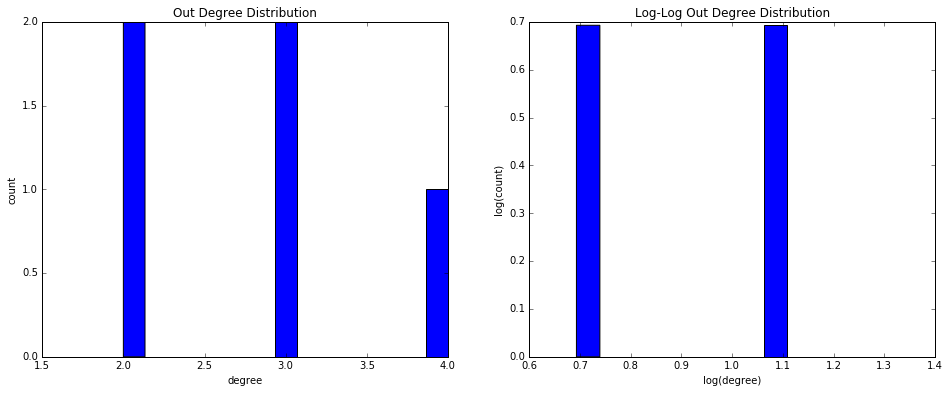

In [7]:
print 'Undirected Toy Data Local'
exploreData('Data/undirected_toy.txt','inline')
generateHistogram('Data/undirected_toy.txt')

Undirected Toy Data  Hadoop
Number of nodes: 5
Number of links: 14.0
Average links: 2.8


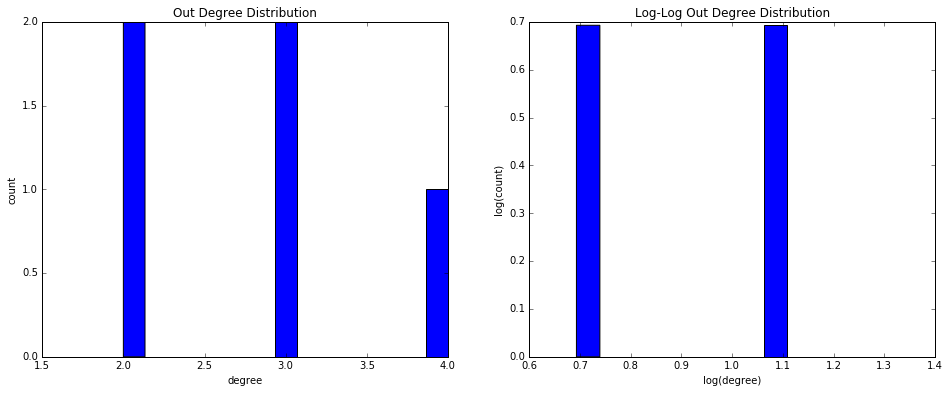

In [218]:
print 'Undirected Toy Data  Hadoop'
exploreData('Data/undirected_toy.txt','hadoop')
generateHistogram('Data/undirected_toy.txt')


Directed toy data on local
Number of nodes: 6
Number of links: 12.0
Average links: 2.0


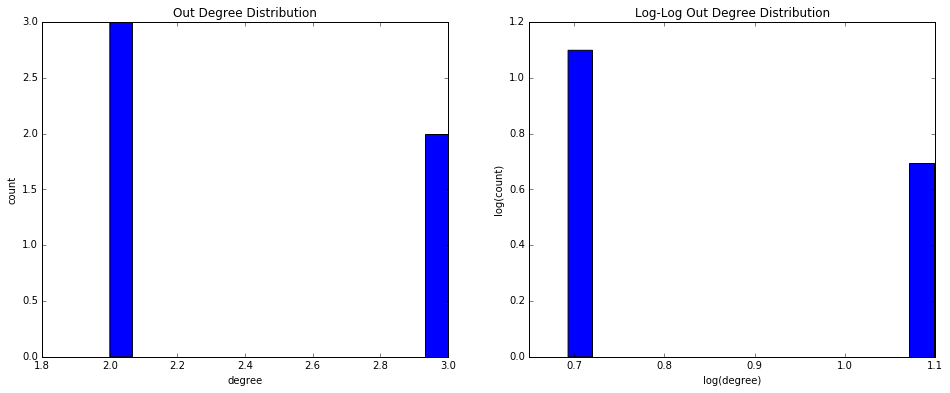

In [22]:
print 'Directed Toy Data Local'
exploreData('Data/directed_toy.txt','inline')
generateHistogram('Data/directed_toy.txt')


Directed Toy Data Hadoop
Number of nodes: 6
Number of links: 12.0
Average links: 2.0


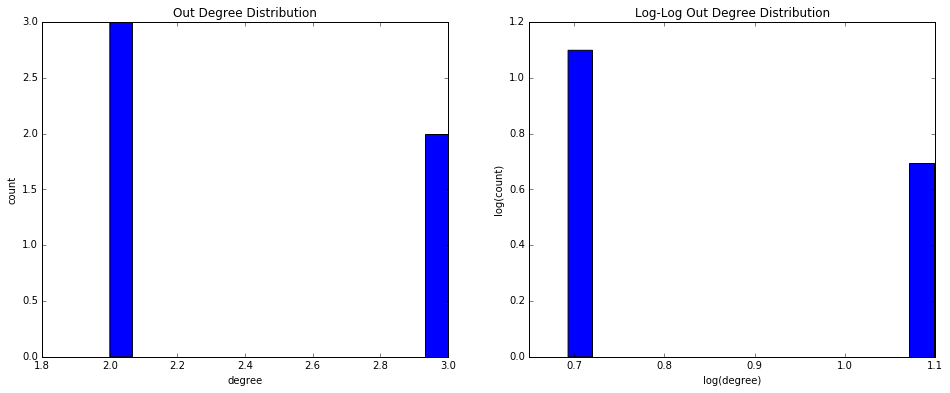

In [46]:
print 'Directed Toy Data Hadoop'
exploreData('Data/directed_toy.txt','hadoop')
generateHistogram('Data/directed_toy.txt')


Now run on the full data set for real

NLTK Synonyms Local
Number of nodes: 8271
Number of links: 61134.0
Average links: 7.39136742836


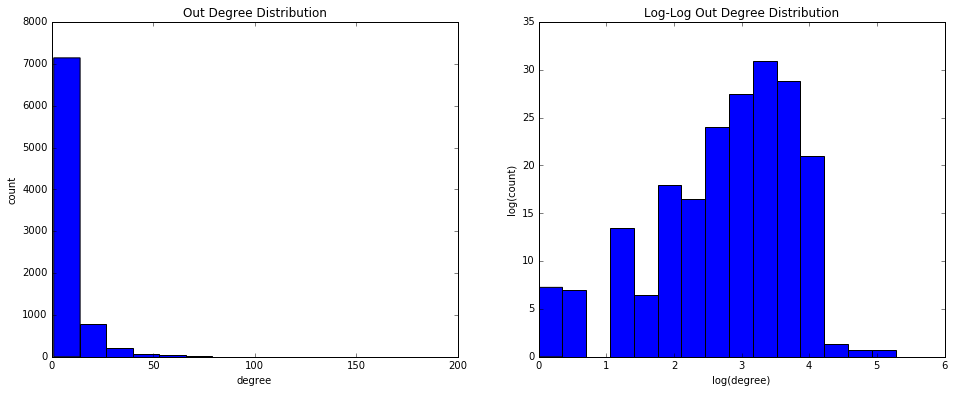

In [47]:
print 'NLTK Synonyms Local'
exploreData('Data/synNet/synNet.txt','inline')
generateHistogram('Data/synNet/synNet.txt')


NLTK Synonyms Hadoop
Number of nodes: 8271
Number of links: 61134.0
Average links: 7.39136742836


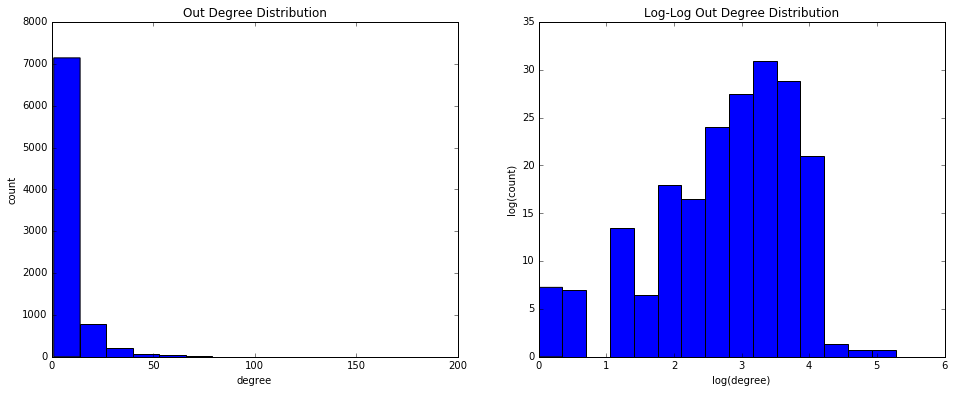

In [48]:
print 'NLTK Synonyms Hadoop'
exploreData('Data/synNet/synNet.txt','hadoop')
generateHistogram('Data/synNet/synNet.txt')

<h1 style="color:#021353;">HW 7.2: Shortest path graph distances (NLTK synonyms)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

=====================================
<strong>NOTE: Dataset 2 English Wikipedia hyperlink network.data </strong>
The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

on S3 at 
<a href="s3://ucb-mids-mls-networks/wikipedia/">s3://ucb-mids-mls-networks/wikipedia/</a>
<a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt</a> # Graph
<a href="s3://ucb-mids-mls-networks/wikipedia/indices.txt">s3://ucb-mids-mls-networks/wikipedia/indices.txt</a> # Page titles and page Ids

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/indices.txt">s3://ucb-mids-mls-networks/wikipedia/indices.txt</a>

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

</pre>
</div>

In [20]:
print "NLTK Synonyms Shortest Path Local"
findShortestPath('Data/synNet/synNet.txt Data/synNet/indices.txt', 'walk', 'make','local')

NLTK Synonyms Shortest Path Local


['walk', 'passes', 'reach', 'make']

In [21]:
print "NLTK Synonyms Shortest Path Hadoop"
findShortestPath('Data/synNet/synNet.txt Data/synNet/indices.txt', 'walk', 'make','hadoop')

NLTK Synonyms Shortest Path Hadoop


['walk', 'passes', 'reach', 'make']

<h1 style="color:#021353;">HW 7.3: Exploratory data analysis (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 

Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 

This means that you may have to ADJUST your code (depending on its design). 

To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.
</pre>
</div>

Wikipedia Out Data
Number of nodes: 15192277
Number of links: 142114057.0
Average links: 9.35436189058


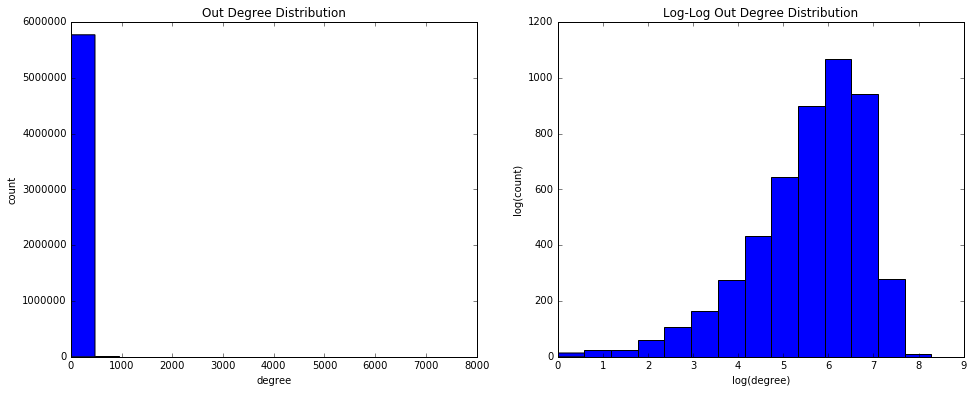

In [29]:
print 'Wikipedia Out Data'
exploreData('Data/wikipedia/all-pages-indexed-out.txt','hadoop')
generateHistogram('Data/wikipedia/all-pages-indexed-out.txt')


<h1 style="color:#021353;">HW 7.4: Shortest path graph distances (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.
</pre>
</div>

In [30]:
print "Wikiedpia Shortest Path Between Ireland and University of California, Berkeley"
path = findShortestPath('Data/wikipedia/all-pages-indexed-out.txt Data/wikipedia/indices.txt'
                        ,'Ireland', 'University of California, Berkeley','hadoop')
print path

Wikiedpia Shortest Path Between Ireland and University of California, Berkeley
['Ireland', 'Seamus Heaney', 'University of California, Berkeley']


In [5]:
print "Wikiedpia Shortest Path Between Nelson_le_Follet and Mairy"
path = findShortestPath('Data/wikipedia/all-pages-indexed-out.txt Data/wikipedia/indices.txt',
                        'Nelson_le_Follet', 'Mairy','hadoop')
print path

Wikiedpia Shortest Path Between Nelson_le_Follet and Mairy


Exception: No path

<h1 style="color:#021353;">HW 7.5: Conceptual exercise: Largest single-source network distances</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...
</pre>
</div>

At the moment, I think I would implement this task by checking each permutation of the N -2 non-start or end nodes in the network. For each permutation, I'd check if that path is possibe from the start node to the end node.  If while transversing a permutation, I find that the next node is not reachable from the current node, just drop the next node from the permutation and try to move to the node after that. Once all permutations have been checked, return the one with the longest length that reaches the end node.  If all N-2 nodes on a permutation are reachable in order, then terminate early and return that permutation (you can't have a longer path than N).

The main difference between the task of finding the longest path and finding the shortest path is that the task of finding the shortest path needs to only visit each node once, giving it a worst case run time of O(N+E).  In contrast, the task of finding the longest path must revisit nodes.

The task of finding the longest path would be significantly more difficult than the task of finding the shortest path.  It has O(N(N-2)!) complexity, far greater than the O(N+E) complexity for the task of finding the shortest path.  While the meat of this task can be accomplished in parallel with (N-2)! machines (each machine would transverse one of the (N-2)! permutations), you still would inenvitably need to find the maximum length of each of the found paths, and that comparison alone would take O((N-2)!) time.  

<h1 style="color:#021353;">HW 7.5.1: </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Can we utilize combiners in the HW 7 to perform the shortest path implementation?
Does order inversion help with the HW 7 shortest path implementation?
</pre>
</div>

Combiners can help in the shortest path implementation.  In theory, you could benefit from a combiner in instances where a queued node is on the same mapper as one of its neighbors.  The combiner would combine the two yields from the mapper and send just one in queued node with complete information to the reducer.  However, the reducer would need to be modified to handle queued nodes from the mapper that may have complete or incomplete information.

While order inversion may speed up some parts of the task, it is not technically neccesary for my shortest path implementation, at least not in my implementation.  Each of my reducer functions will yield only one record per input key, so one could you collect all the values first and then process and yield in a reducer_final.  However, order inversion in my implementation saves some time by making the reducers run the termination checks before processing the node information from the mappers.  If a termination condition is met, then all the work by the reducer is going to be discarded anyway, so it's better to perform the termination check upfront rather than let the reducer process node information first.

<h1 style="color:#021353;">HW 7.5.2: OPTIONAL </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Implement combiners in the context of HW 7.5 and contrast the performance of this implementation versus the implementation with no combiners. 

Please report the cluster configuration and runtimes in tabular format for both experiments and comment on your findings.
</pre>
</div>

<h1 style="color:#021353;">HW 7.6: Computational exercise: Largest single-source network distances: OPTIONAL </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.
</pre>
</div>

==================END HW 7==================